In [67]:
import skimage
import numpy as np
import statistics

from glob import glob as show_dir_files
from scipy import ndimage as ndi
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from skimage.io import imread
from skimage.color import rgb2gray
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from skimage.measure import label, regionprops
from sklearn.metrics import pairwise_distances_argmin
from skimage import filters, measure, morphology, exposure
import numpy as np
import statistics
import tifffile

from skimage.color import rgb2gray
from skimage import (filters,
                     measure,
                     exposure,
                     morphology)
from tqdm import tqdm
from glob import glob

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [32]:
def plot_images(arr_images=[], grid=(2, 2), cmap="inferno"):

    if grid == None:
        grid = (1, 1)
        
    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111,
                     nrows_ncols=grid,
                     axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()

In [33]:
def smoothing_edges(mask):
    
    def find_bighest_cluster_area(clusters):
        regions = measure.regionprops(clusters)
        regions_area = map(lambda x: x.area, regions)
        return max(regions_area)

    #Converte em imagem binária
    mask = binarize_image(mask) 

    #Corrige imagem segmentada
    if statistics.mode(mask.flatten()):
        mask = np.invert(mask)

    #/ Seleciona maior objeto da imagem
    clusters = measure.label(mask, background=0)
    mask_size = find_bighest_cluster_area(clusters)
    mask = morphology.remove_small_objects(mask,
                                           min_size=(mask_size - 1),
                                           connectivity=16)
    #/
    
    #Conecta arestas proximas
    mask = morphology.closing(mask, morphology.disk(5))
    
    #Preenche buracos na imagem
    mask = ndi.binary_fill_holes(mask)
    
    #Aplica filtro de blur
    mask = filters.gaussian(mask, sigma=0.5)

    #Retorna a imagem bem delineada/refinada (smoothing)
    return binarize_image(mask)

In [68]:
def apply_k_means(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
    kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)

    labels = kmeans.predict(image_array)

    return kmeans.cluster_centers_[labels].reshape(w, h, -1)

def apply_k_random(image, n_colors=3):

    w, h, d = image.shape

    image_array = np.reshape(image, (w * h, d))

    codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
   
    labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)

    return codebook_random[labels_random].reshape(w, h, -1)


def apply_k_kmeans_gray(image, n_colors=3):
    
    k_means = KMeans(n_colors, n_init=4)
    k_means.fit(image.reshape((-1, 1)))
   
    values = k_means.cluster_centers_.squeeze()
    labels = k_means.labels_

    image_compressed = np.choose(labels, values)
    image_compressed.shape = image.shape
    
    return image_compressed

def normalize_image(image):
    return (image - np.min(image)) / (np.max(image) - np.min(image))

def run_pipe(segmenter, image, n_colors=3):
    
    image_segments = segmenter(image, n_colors) #Aplicando K-means - Segmentando imagem.
    
    image_gray = image_segments.copy()
    
    if len(image_gray.shape) == 3:
        image_gray = rgb2gray(image_segments) #Convertando imagem RGB para Grayscale
    
    image_mask = smoothing_edges(image_gray) #Aplicando binarizador e smoothing de mask
    
    return image_segments, image_gray, image_mask

def binarize_image(arr):
    return arr > filters.threshold_triangle(arr)

def each_ch_hist(image):
    
    image_hist = image.copy()
    
    for ch in range(3):
        image_hist[:, :, ch] = exposure.equalize_hist(image[:, :, ch])
    
    return image_hist

In [69]:
import cv2

def check_colision_border(mask):

    x, *_ = mask.shape

    left = mask[:1, ].flatten()
    right = mask[x - 1: x, ].flatten()
    top = mask[:, : 1].flatten()
    bottom = mask[:, x - 1: x].flatten()

    borders_flatten = [left, right, top, bottom]

    if np.concatenate(borders_flatten).sum():
        return True

    return False

def make_mask(image):
    
    def apply_thresh(image, block_size=1, thresh_type=199):
        return cv2.adaptiveThreshold(image, 
                                 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY_INV, 
                                 thresh_type, 
                                 block_size).astype(bool)
    mask = apply_thresh(image)
    
    if check_colision_border(mask):
        for block in range(1, 30):

            mask = mask = apply_thresh(image, block)
            
            if not check_colision_border(mask): break
    return mask

In [90]:


def plot(arr_images=[], grid=(1, 1), cmap="inferno"):

    fig = plt.figure(figsize=(20, 10))

    grid = ImageGrid(fig, 111,
                   nrows_ncols=grid,
                   axes_pad=0.1)

    for ax, img in zip(grid, arr_images):
        ax.imshow(img, cmap)
        ax.axis('off')

    plt.show()

def binarize_image(arr):
    return arr > filters.threshold_triangle(arr)

def rescale_arr(arr, scale=255):
    return (arr * scale).astype('uint8')

def load_paths_images_sorted(path):

    """
    Carrega caminho da simagens e ordena em onrdem crescente os frames.
    """

    arr = []

    def parser_image_name(image_name):

        *_, name = image_name.split("/")
        name, *_ = name.split(".")

        return int(name)



    for index in tqdm(glob(f'{path}/*')):
        try:
            image_name = parser_image_name(index)

            arr.append(image_name)

        except: continue

    image_path_sorted = sorted(arr)

    image_unique_name = lambda x: f"{path}/{x}.tif"

    return list(map(image_unique_name, image_path_sorted))


def load_images_from_paths(arr_paths, is_gray=False):
    arr_images = []

    if is_gray:
        for img_path in tqdm(arr_paths):

            try:
                frame = rgb2gray(tifffile.imread(img_path))

                is_valid_frame = statistics.mode(binarize_image(frame).flatten())

                if not is_valid_frame:
                    continue

                arr_images.append(rescale_arr(frame))
            except: continue
    else:
        for img_path in tqdm(arr_paths):
            try:
                frame = tifffile.imread(img_path)

                is_valid_frame = statistics.mode(binarize_image(frame).flatten())

                if not is_valid_frame:
                    continue

                arr_images.append(frame)
            except: continue
    return np.asarray(arr_images)


def auto_invert_image_mask(arr):

    """
    Calcula os pixels da imagem e inverte os pixels da imagem caso os pixels True > False
    Isso é uma forma de garatir que as mascaras tenham sempre o fundo preto = 0 e o ROI = 1
    """

    img = arr.copy()

    if statistics.mode(img.flatten()):
        img = np.invert(img)

    return img

def find_bighest_cluster_area(clusters):
    regions = measure.regionprops(clusters)

    all_areas = map(lambda item: item.area, regions)

    return max(all_areas)

def find_bighest_cluster(img):

    clusters = auto_invert_image_mask(img)

    clusters = measure.label(clusters, background=0)

    cluster_size = find_bighest_cluster_area(clusters)

    return morphology.remove_small_objects(clusters,
                                         min_size=(cluster_size - 1),
                                         connectivity=8)

In [91]:
def rescale_arr(arr, scale=255):
    return (arr * scale).astype('uint8')

from skimage.transform import rescale

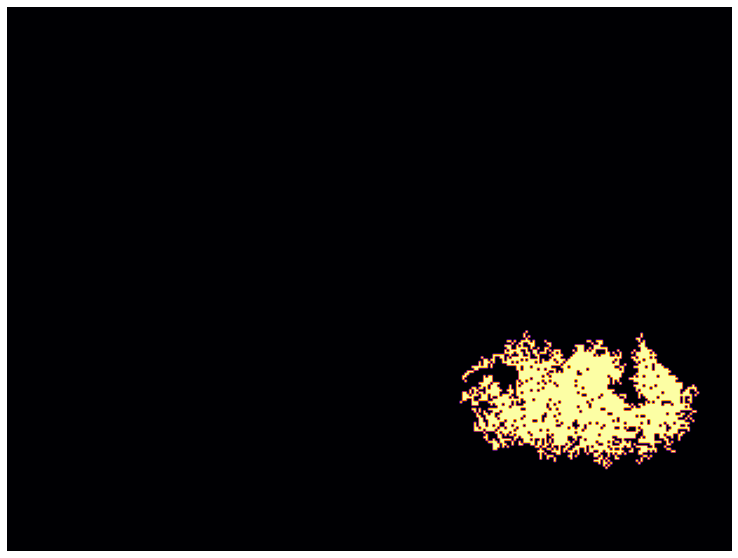

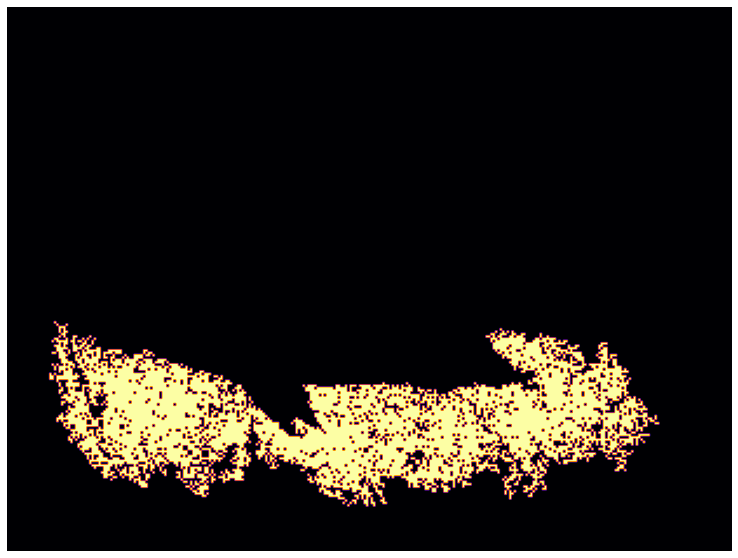

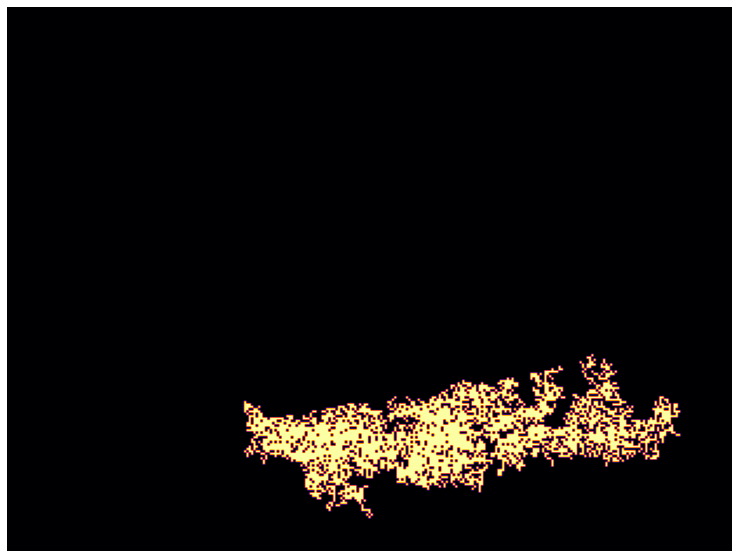

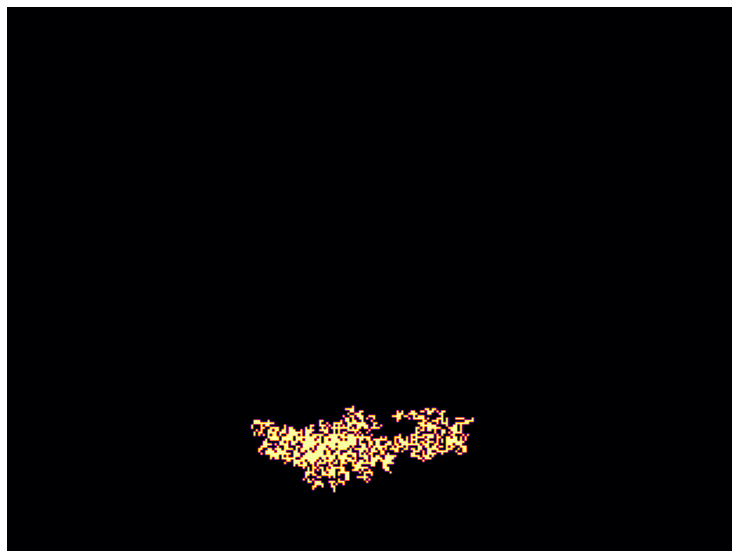

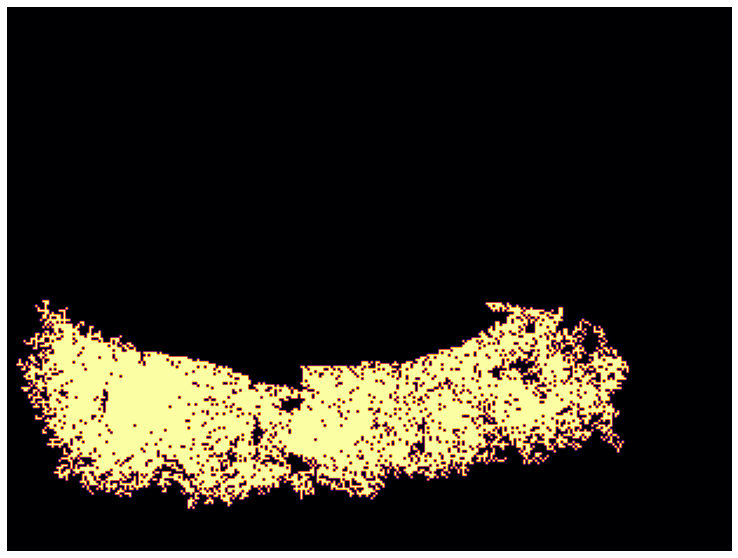

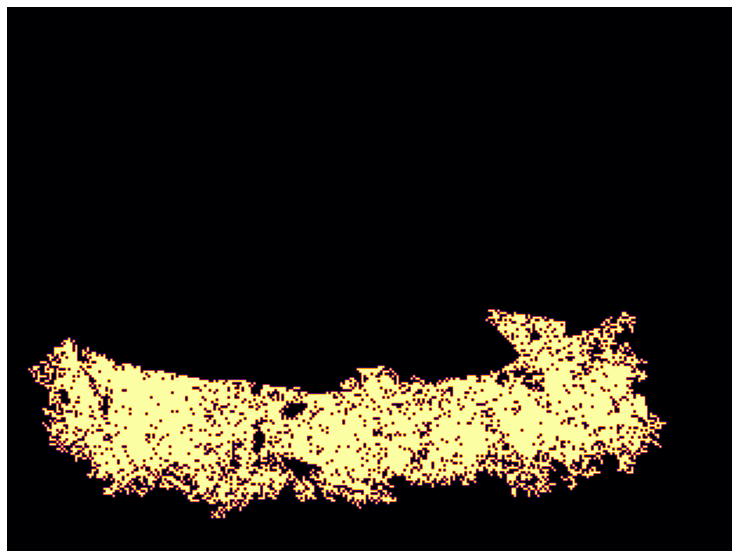

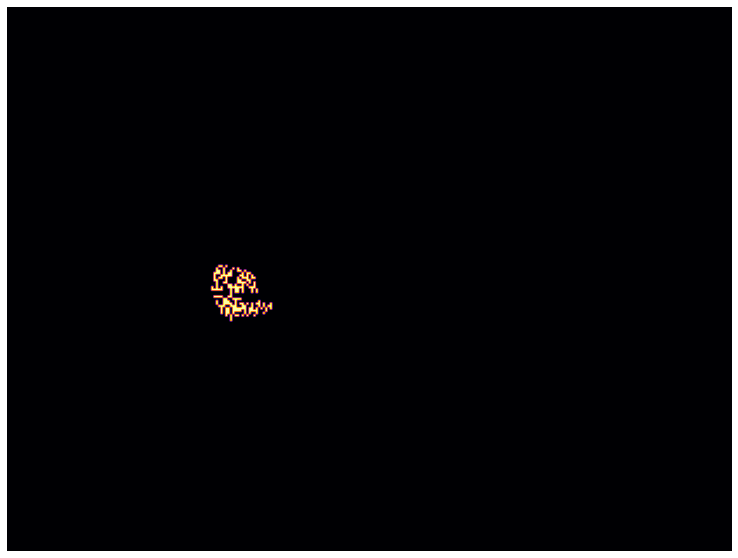

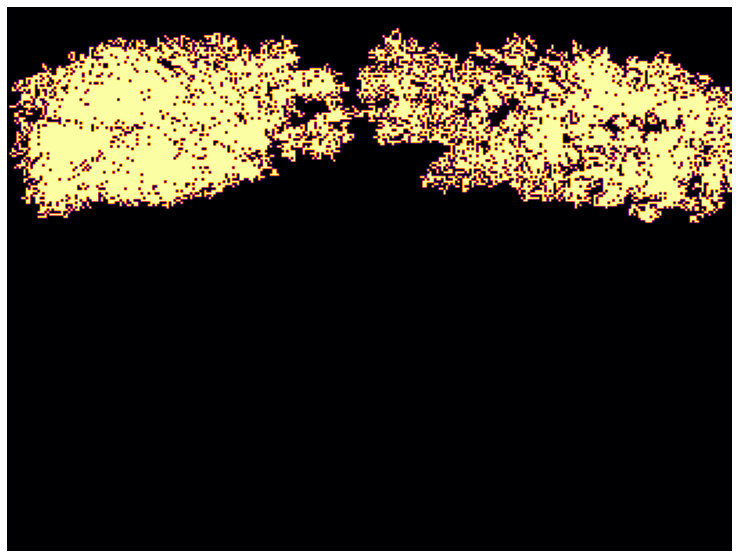

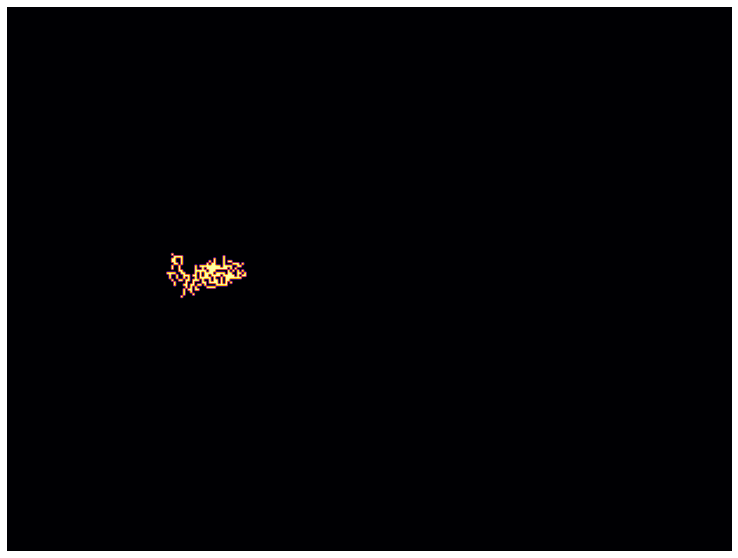

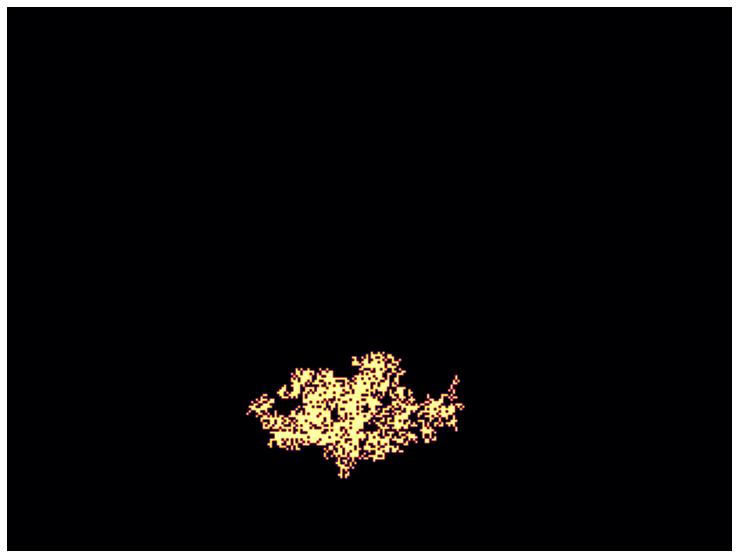

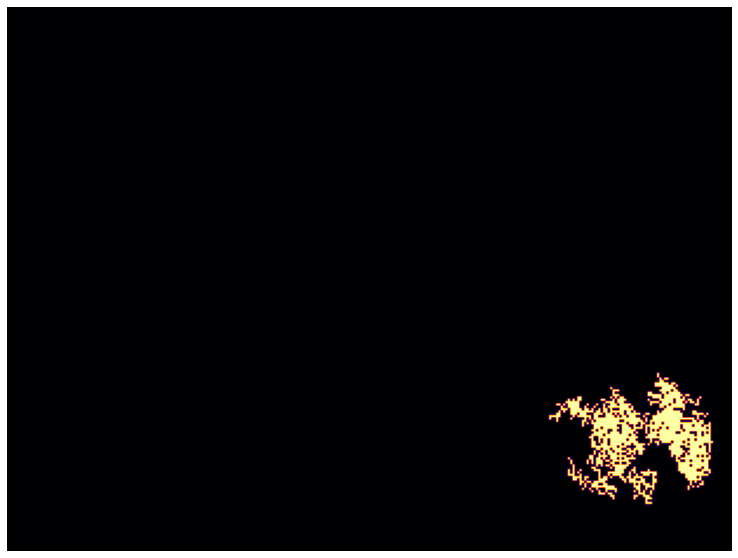

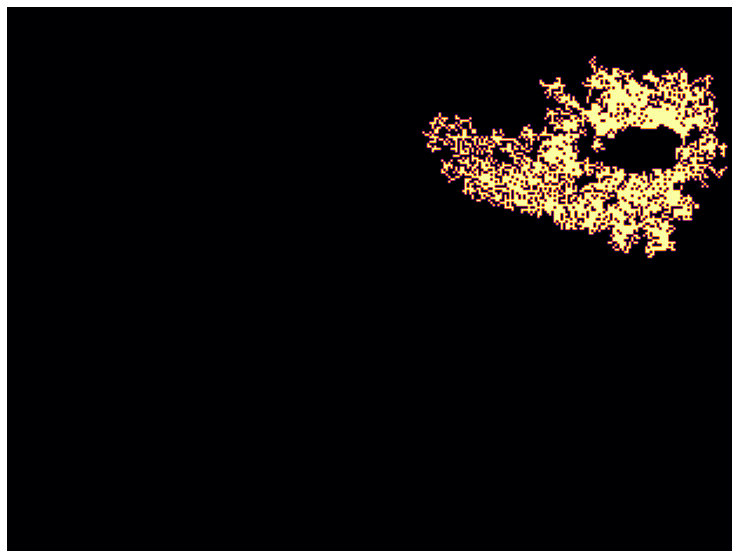

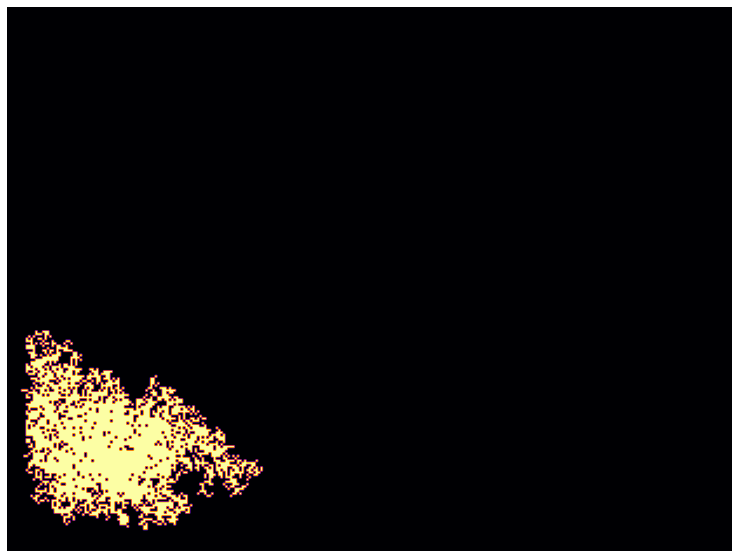

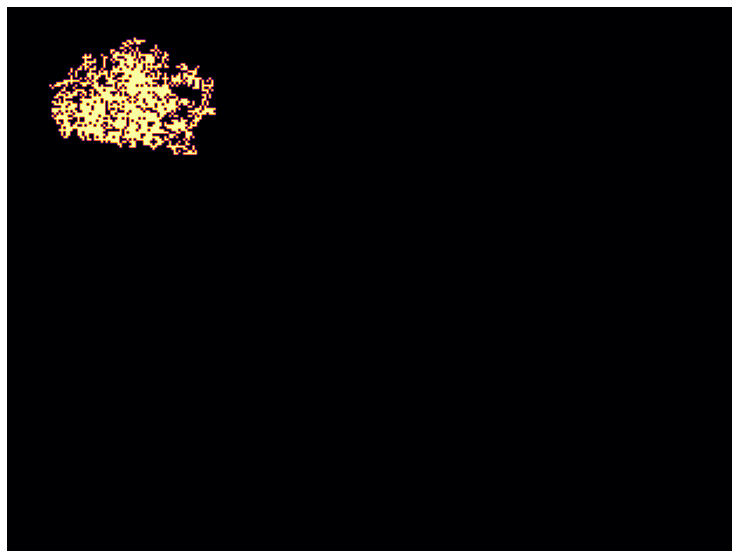

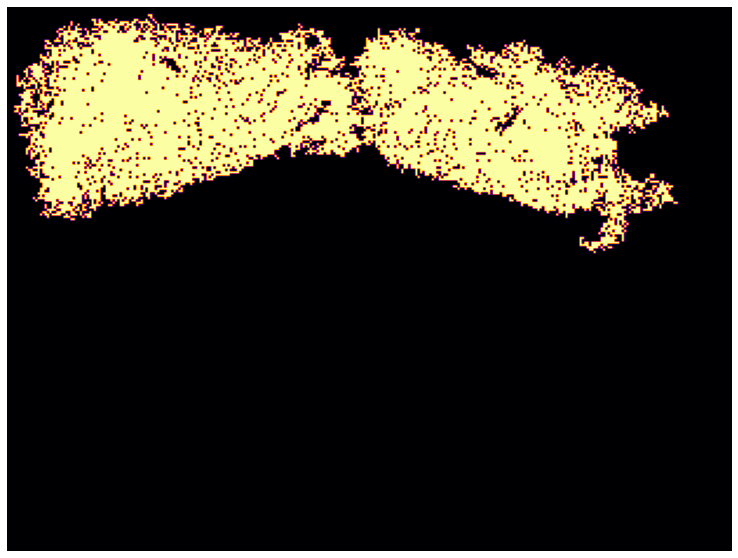

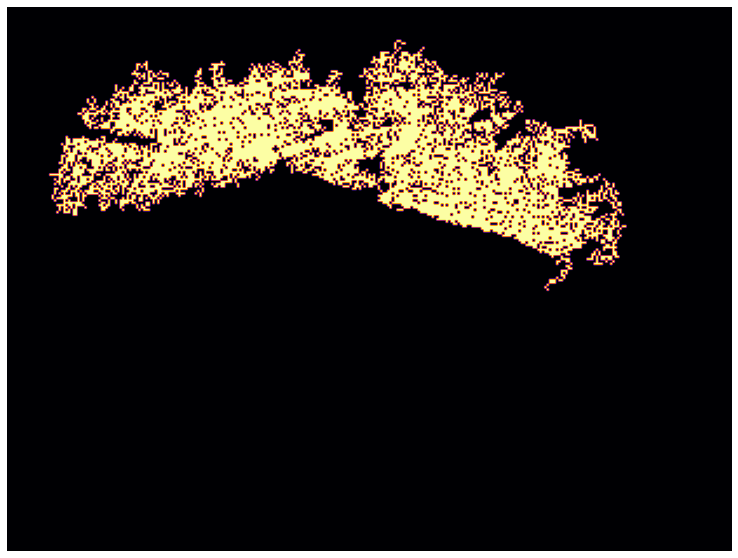

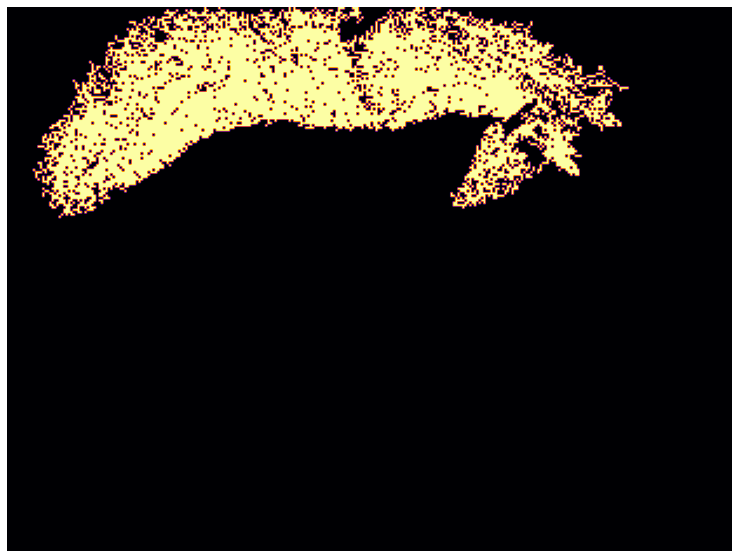

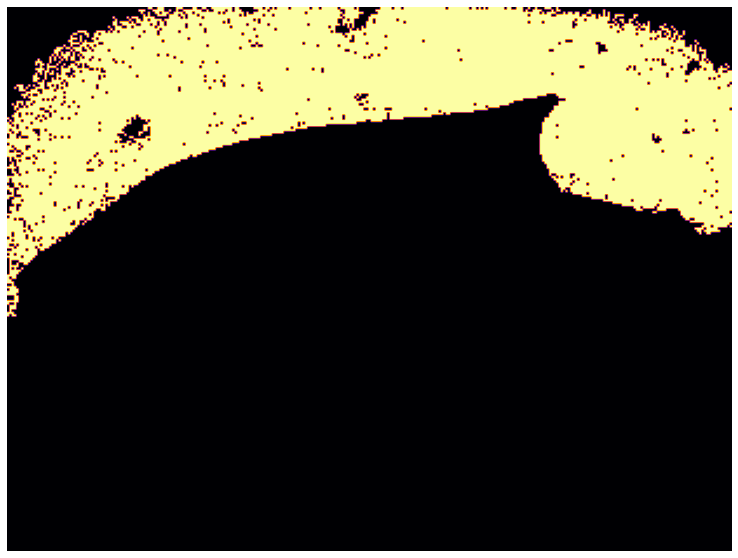

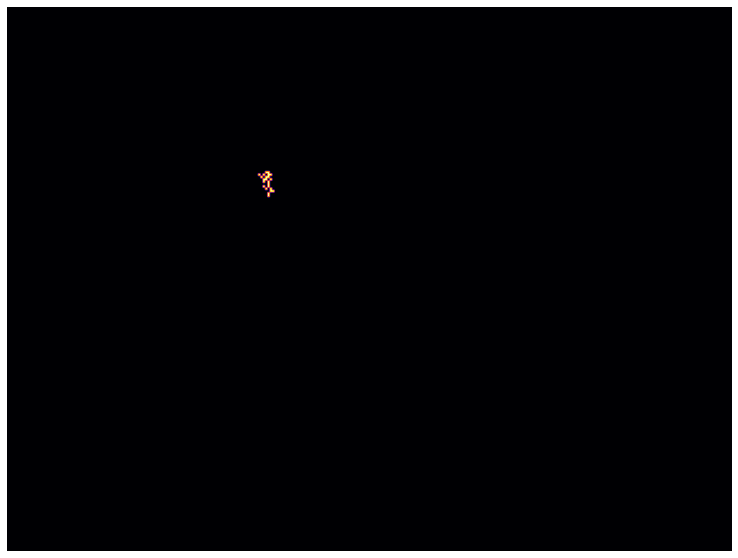

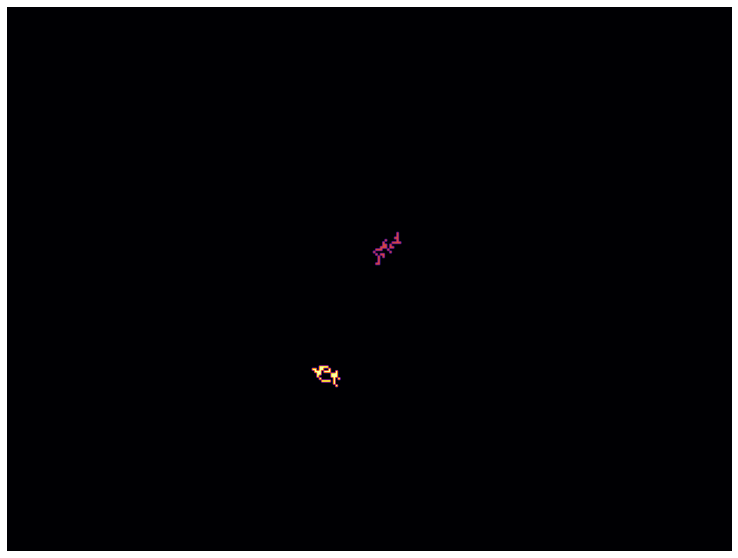

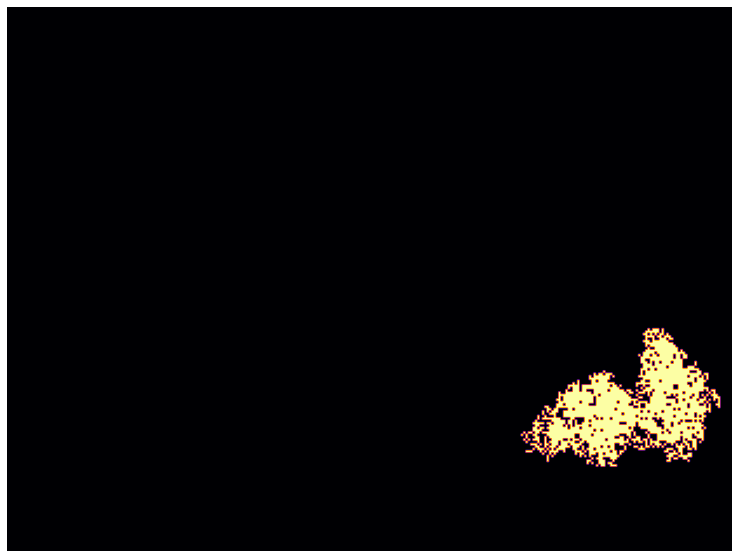

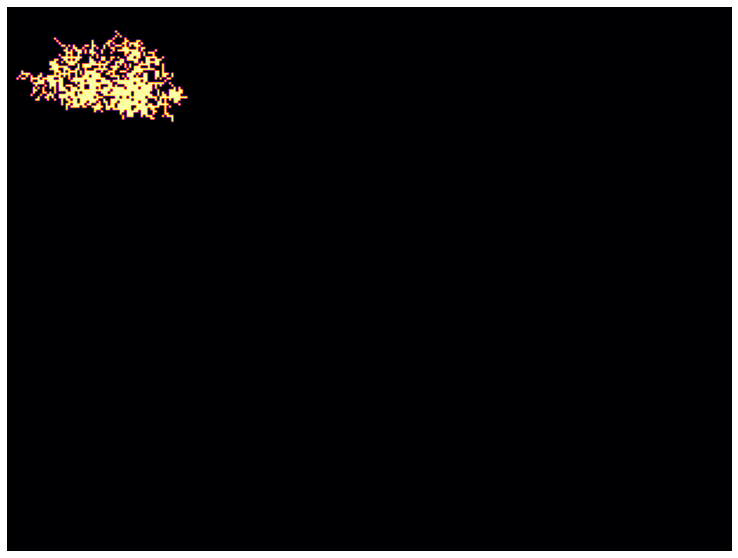

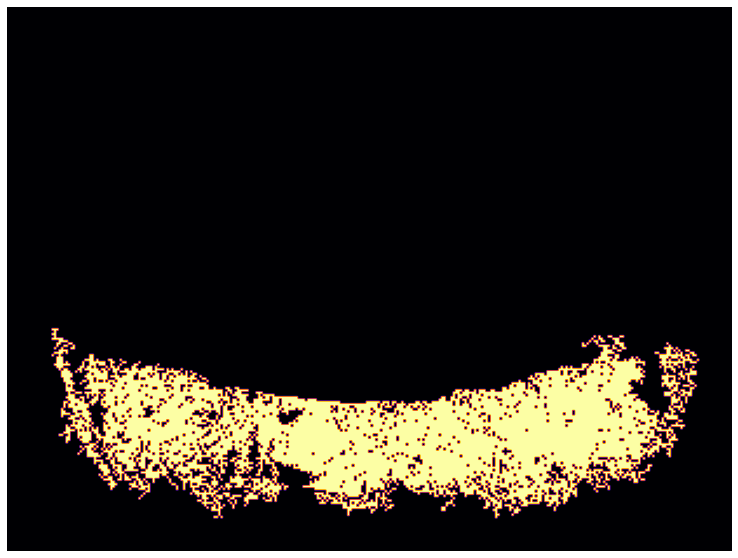

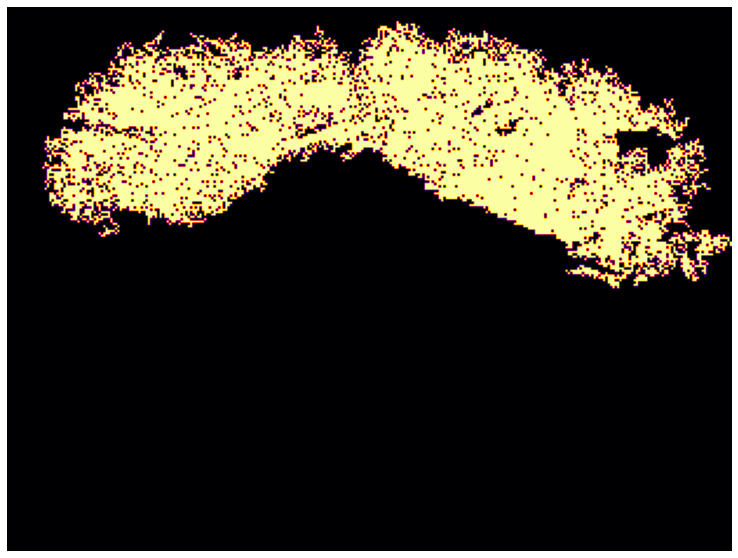

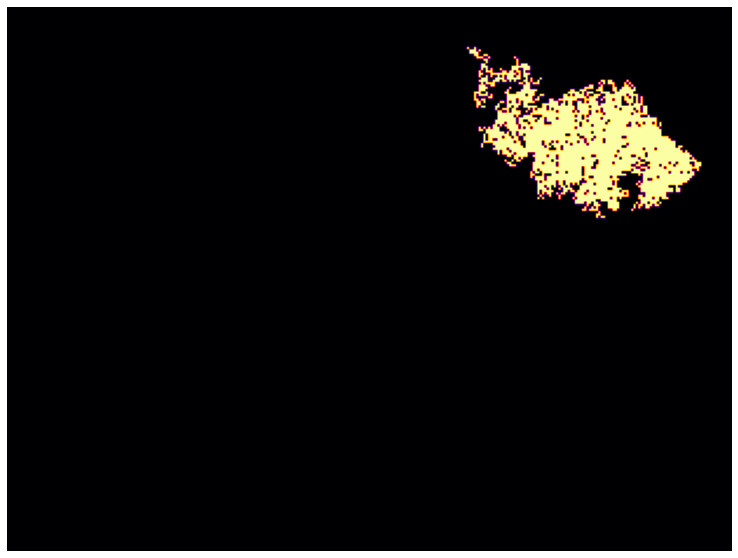

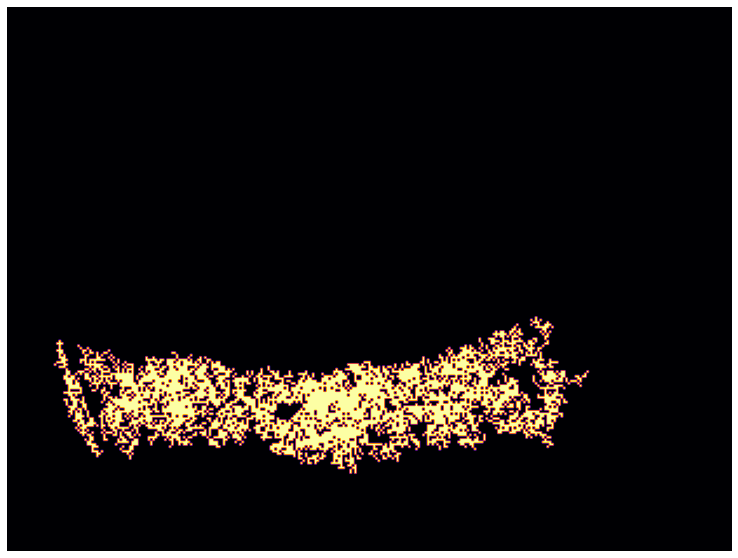

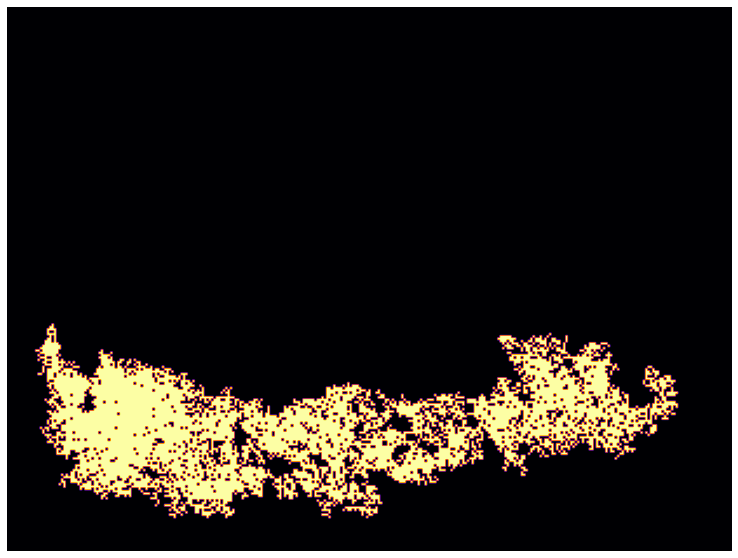

In [96]:
for img_path in show_dir_files("../data/images/*"):
    ######################
    image_resized = imread(img_path)[::15, ::15]
    # image_resized = normalize_image(image_resized)
    image_gray = image_resized[:,:,1]#rgb2gray(image_resized)
    mask = make_mask(rescale_arr(image_gray))
    maskii = find_bighest_cluster(mask)
    plot_images([maskii], (1, 1))
    #####################
    
    # image_hist = each_ch_hist(image_resized)
    
    # plot_images([image_resized, image_hist], (1, 2))
    
    # image_segments, image_gray, image_mask = run_pipe(apply_k_kmeans_gray, image_hist[:, :, 2], n_colors=3)
    # plot_images([image_resized, image_hist, image_segments, image_mask], (1, 4))

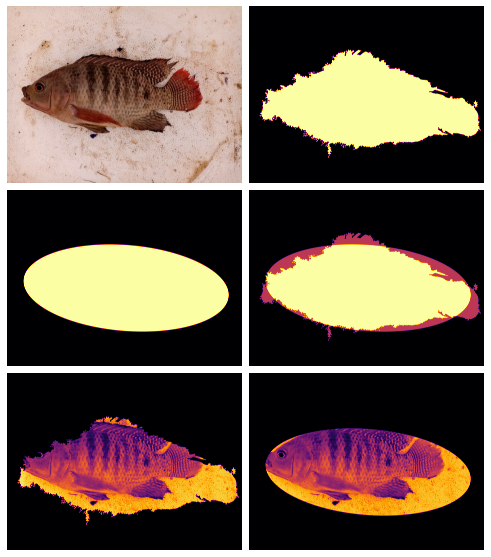

In [16]:
mask = image_mask

region = label(mask)

props = regionprops(region)
props = props[0]

y0, x0 = props.centroid

rr,cc = skimage.draw.ellipse_perimeter(int(x0), 
                                       int(y0), 
                                       int(props.minor_axis_length * 0.5), 
                                       int(props.major_axis_length * 0.5), 
                                       orientation=props.orientation)



x = np.zeros(mask.shape)
x[cc, rr] = 1
masc = ndi.binary_fill_holes(x)


plot_images([image_resized,
             mask,
             masc, 
             masc + (mask + 1),
             image_resized[:,:,0] * mask, 
             image_resized[:,:,0] * masc], (3, 2))